In [7]:
## data is taken from https://baseballsavant.mlb.com/statcast_search?hfPT=&hfAB=&hfGT=R%7C&hfPR=&hfZ=&hfStadium=&hfBBL=&hfNewZones=&hfPull=&hfC=&hfSea=2025%7C&hfSit=&player_type=pitcher&hfOuts=&hfOpponent=&pitcher_throws=&batter_stands=&hfSA=&game_date_gt=&game_date_lt=&hfMo=&hfTeam=134%7C&home_road=&hfRO=&position=&hfInfield=&hfOutfield=&hfInn=&hfBBT=&hfFlag=&metric_1=&group_by=name&min_pitches=0&min_results=0&min_pas=0&sort_col=pitches&player_event_sort=api_p_release_speed&sort_order=desc#results

In [109]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import precision_recall_curve, average_precision_score, classification_report, roc_auc_score
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.api as sm
import seaborn as sns
from sklearn.metrics import classification_report, roc_auc_score, brier_score_loss, precision_score, recall_score, f1_score
import pandas as pd
import statsmodels.api as sm
import numpy as np
import re
import xgboost as xgb
import shap
from sklearn.model_selection import train_test_split



pd.set_option('display.max_columns', None) 

#  Load data (downloaded from Baseball Savant for Pirates pitchers)
# data = pd.read_csv('/Users/romankoshovnyk/savant_data_pirates.csv')  
# Download dataset from GitHub 
csv_url = 'https://raw.githubusercontent.com/Shargat1996/pirates_sandbox/refs/heads/main/savant_data_pirates.csv'
# Load dataset
data = pd.read_csv(csv_url)
data.head()

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,spin_dir,spin_rate_deprecated,break_angle_deprecated,break_length_deprecated,zone,des,game_type,stand,p_throws,home_team,away_team,type,hit_location,bb_type,balls,strikes,game_year,pfx_x,pfx_z,plate_x,plate_z,on_3b,on_2b,on_1b,outs_when_up,inning,inning_topbot,hc_x,hc_y,tfs_deprecated,tfs_zulu_deprecated,umpire,sv_id,vx0,vy0,vz0,ax,ay,az,sz_top,sz_bot,hit_distance_sc,launch_speed,launch_angle,effective_speed,release_spin_rate,release_extension,game_pk,fielder_2,fielder_3,fielder_4,fielder_5,fielder_6,fielder_7,fielder_8,fielder_9,release_pos_y,estimated_ba_using_speedangle,estimated_woba_using_speedangle,woba_value,woba_denom,babip_value,iso_value,launch_speed_angle,at_bat_number,pitch_number,pitch_name,home_score,away_score,bat_score,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment,spin_axis,delta_home_win_exp,delta_run_exp,bat_speed,swing_length,estimated_slg_using_speedangle,delta_pitcher_run_exp,hyper_speed,home_score_diff,bat_score_diff,home_win_exp,bat_win_exp,age_pit_legacy,age_bat_legacy,age_pit,age_bat,n_thruorder_pitcher,n_priorpa_thisgame_player_at_bat,pitcher_days_since_prev_game,batter_days_since_prev_game,pitcher_days_until_next_game,batter_days_until_next_game,api_break_z_with_gravity,api_break_x_arm,api_break_x_batter_in,arm_angle,attack_angle,attack_direction,swing_path_tilt,intercept_ball_minus_batter_pos_x_inches,intercept_ball_minus_batter_pos_y_inches
0,FF,2025-06-09,94.9,-0.82,6.29,"Burrows, Mike",660821,681347,sac_fly,hit_into_play,NaN,NaN,NaN,NaN,5,Jesús Sánchez out on a sacrifice fly to left f...,R,L,R,PIT,MIA,X,7.0,fly_ball,1,0,2025,-0.46,1.38,-0.02,2.81,681715.0,NaN,669364.0,0,5,Top,53.51,120.77,NaN,NaN,NaN,NaN,3.135994,-137.982572,-6.498342,-6.557993,33.021365,-13.277058,3.40,1.57,275.0,85.2,46.0,95.1,2283,6.6,777574,664954,687462,693304,663647,669707,624428,665833,668804,53.90,0.014,0.021,0.0,1.0,0.0,0.0,3.0,38,2,4-Seam Fastball,4,1,1,4,2,4,2,4,Standard,Standard,205,0.042,-0.264,70.4,6.4,0.032,0.264,88.0,3,-3,0.714,0.286,25,27,26,28,3,2,NaN,NaN,NaN,NaN,1.17,0.46,-0.46,NaN,-2.724609,9.413360,26.884283,36.421627,27.690714
1,FF,2025-06-09,94.4,-0.81,6.31,"Burrows, Mike",660821,681347,NaN,ball,NaN,NaN,NaN,NaN,11,Jesús Sánchez out on a sacrifice fly to left f...,R,L,R,PIT,MIA,B,NaN,NaN,0,0,2025,-0.49,1.45,-1.00,3.44,681715.0,NaN,669364.0,0,5,Top,NaN,NaN,NaN,NaN,NaN,NaN,0.595508,-137.303220,-4.952049,-6.300183,34.017916,-12.968651,3.40,1.57,NaN,NaN,NaN,94.2,2266,6.5,777574,664954,687462,693304,663647,669707,624428,665833,668804,54.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38,1,4-Seam Fastball,4,1,1,4,1,4,1,4,Standard,Standard,206,0.000,0.021,NaN,NaN,NaN,-0.021,NaN,3,-3,0.714,0.286,25,27,26,28,3,2,NaN,NaN,NaN,NaN,1.13,0.49,-0.49,NaN,NaN,NaN,NaN,NaN,NaN
2,FF,2025-06-09,94.3,-1.03,6.16,"Burrows, Mike",669364,681347,field_error,hit_into_play,NaN,NaN,NaN,NaN,6,Xavier Edwards reaches on a fielding error by ...,R,L,R,PIT,MIA,X,4.0,ground_ball,1,1,2025,-0.40,1.40,0.55,2.51,NaN,681715.0,NaN,0,5,Top,158.91,159.79,NaN,NaN,NaN,NaN,4.999153,-137.032533,-6.868551,-6.167512,33.122730,-13.214650,3.33,1.50,40.0,96.8,-1.0,94.3,2312,6.6,777574,664954,687462,693304,663647,669707,624428,665833,668804,53.91,0.369,0.355,0.9,1.0,0.0,0.0,2.0,37,3,4-Seam Fastball,4,1,1,4,1,4,1,4,Standard,Standard,207,-0.074,0.458,66.3,5.8,0.409,-0.458,96.8,3,-3,0.788,0.212,25,25,26,26,3,2,NaN,NaN,NaN,NaN,1.19,0.40,-0.40,NaN,0.774703,-1.819191,36.132249,25.694900,28.128908
3,FF,2025-06-09,95.0,-0.65,6.29,"Burrows, Mike",669364,681347,NaN,called_strike,NaN,NaN,NaN,NaN,8,Xavier Edwards reaches on a fielding error by ...,R,L,R,PIT,MIA,S,NaN,NaN,1,0,2025,-0.52,1.48,0.13,1.55,NaN,681715.0,NaN,0,5,Top,NaN,NaN,NaN,NaN,NaN,NaN,3.230261,-137.979993,-10.055122,-7.371367,31.121721,-11.273816,3.33,1.50,NaN,NaN,NaN,95.2,2341,6.5,777574,664954,687462,693304,663647,669707,624428,665833,668804,53.95,

In [123]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9587 entries, 0 to 9586
Columns: 121 entries, pitch_type to is_strike_pitch
dtypes: category(2), float64(64), int64(38), object(17)
memory usage: 8.7+ MB


In [124]:
data.describe()

,release_speed,release_pos_x,release_pos_z,batter,pitcher,spin_dir,spin_rate_deprecated,break_angle_deprecated,break_length_deprecated,zone,hit_location,balls,strikes,game_year,pfx_x,pfx_z,plate_x,plate_z,on_3b,on_2b,on_1b,outs_when_up,inning,hc_x,hc_y,tfs_deprecated,tfs_zulu_deprecated,umpire,sv_id,vx0,vy0,vz0,ax,ay,az,sz_top,sz_bot,hit_distance_sc,launch_speed,launch_angle,effective_speed,release_spin_rate,release_extension,game_pk,fielder_2,fielder_3,fielder_4,fielder_5,fielder_6,fielder_7,fielder_8,fielder_9,release_pos_y,estimated_ba_using_speedangle,estimated_woba_using_speedangle,woba_value,woba_denom,babip_value,iso_value,launch_speed_angle,at_bat_number,pitch_number,home_score,away_score,bat_score,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,spin_axis,delta_home_win_exp,delta_run_exp,bat_speed,swing_length,estimated_slg_using_speedangle,delta_pitcher_run_exp,hyper_speed,home_score_diff,bat_score_diff,home_win_exp,bat_win_exp,age_pit_legacy,age_bat_legacy,age_pit,age_bat,n_thruorder_pitcher,n_priorpa_thisgame_player_at_bat,pitcher_days_since_prev_game,batter_days_since_prev_game,pitcher_days_until_next_game,batter_days_until_next_game,api_break_z_with_gravity,api_break_x_arm,api_break_x_batter_in,arm_angle,attack_angle,attack_direction,swing_path_tilt,intercept_ball_minus_batter_pos_x_inches,intercept_ball_minus_batter_pos_y_inches,is_strike_pitch
count,9587.000000,9587.000000,9587.000000,9587.000000,9587.000000,0.0,0.0,0.0,0.0,9587.000000,2184.000000,9587.000000,9587.000000,9587.0,9587.000000,9587.000000,9587.000000,9587.000000,946.000000,1701.000000,2760.000000,9587.000000,9587.000000,1747.000000,1747.000000,0.0,0.0,0.0,0.0,9587.000000,9587.000000,9587.000000,9587.000000,9587.000000,9587.000000,9587.000000,9587.000000,3238.000000,3222.000000,3227.000000,9584.000000,9587.000000,9587.000000,9587.000000,9587.000000,9587.000000,9587.000000,9587.000000,9587.000000,9587.000000,9587.000000,9587.000000,9587.000000,1742.000000,2450.000000,2467.000000,2462.000000,2467.000000,2467.000000,1742.000000,9587.000000,9587.000000,9587.000000,9587.000000,9587.000000,9587.000000,9587.000000,9587.000000,9587.000000,9587.000000,9587.000000,9587.000000,9586.000000,4425.000000,4425.000000,1742.000000,9586.000000,3237.000000,9587.000000,9587.000000,9587.000000,9587.000000,9587.000000,9587.000000,9587.000000,9587.000000,9587.000000,9587.000000,8591.000000,9186.000000,8607.000000,9251.000000,9587.000000,9587.000000,9587.000000,9423.000000,4425.000000,4425.000000,4425.000000,4422.000000,4422.000000,9587.000000
mean,89.283718,-0.500713,5.617590,649837.809951,658027.686450,NaN,NaN,NaN,NaN,8.842286,5.233974,0.881715,0.895483,2025.0,-0.022500,0.602390,-0.023438,2.334233,643100.980973,654836.566725,646669.334783,1.004381,5.015020,125.429817,125.608798,NaN,NaN,NaN,NaN,1.348389,-129.822346,-3.334714,-1.174035,28.006087,-24.112230,3.420076,1.594767,151.898085,82.674022,16.186241,89.551388,2287.464587,6.550819,778085.816835,671442.134140,676812.305101,640482.499009,663853.244393,649733.767602,569367.952540,667515.355273,642761.234901,53.949434,0.321227,0.318708,0.302675,0.995126,0.187272,0.124848,3.194604,37.810368,2.922082,1.645457,1.792219,1.871180,1.566496,1.807761,1.658287,1.899551,1.566496,178.294566,0.000729,-0.003423,69.149785,7.169672,0.521511,0.003423,91.882422,-0.146761,0.304683,0.505448,0.542941,28.123292,28.174924,28.433712,28.709190,1.497444,1.530093,4.694564,1.380688,4.804229,1.401686,2.309100,0.354233,-0.081862,35.043309,8.392786,-0.412902,31.904268,36.258617,29.758772,0.281944
std,6.007985,2.099858,0.474508,46336.273938,39438.404222,NaN,NaN,NaN,NaN,4.211119,2.578092,0.966142,0.830847,0.0,0.959339,0.681357,0.830540,0.918960,51662.469578,42006.256554,49554.555938,0.809513,2.630207,39.881931,41.127562,NaN,NaN,NaN,NaN,6.589634,8.681911,2.854170,12.041726,3.949102,8.358050,0.205512,0.125534,119.089472,15.577488,33.035774,6.169408,319.835075,0.347487,289.401642,8718.238461,9522.753993,25081.761984,2855.761883,12533.1

## Some visualizations

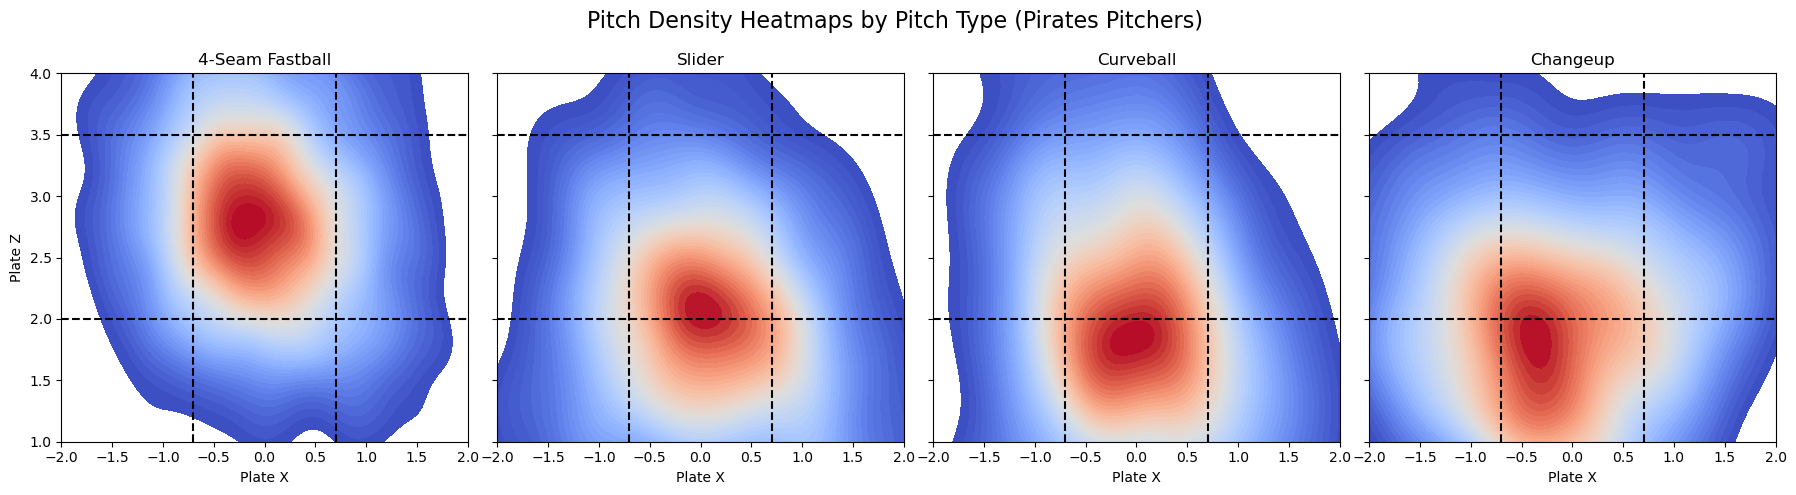

In [110]:

pirates_data = data
pitch_types_to_plot = ['4-Seam Fastball', 'Slider', 'Curveball', 'Changeup']

fig, axes = plt.subplots(1, len(pitch_types_to_plot), figsize=(18, 5), sharey=True)

for ax, pitch in zip(axes, pitch_types_to_plot):
    subset = pirates_data[pirates_data['pitch_name'] == pitch]
    sns.kdeplot(
        data=subset,
        x='plate_x',
        y='plate_z',
        fill=True,
        cmap="coolwarm",
        ax=ax,
        levels=50,
        thresh=0.05
    )
    # Draw strike zone
    ax.set_xlim(-2, 2)
    ax.set_ylim(1, 4)
    ax.axhline(3.5, color='black', linestyle='--')
    ax.axhline(2.0, color='black', linestyle='--')
    ax.axvline(-0.7, color='black', linestyle='--')
    ax.axvline(0.7, color='black', linestyle='--')

    ax.set_title(pitch)
    ax.set_xlabel('Plate X')
    ax.set_ylabel('Plate Z')

fig.suptitle("Pitch Density Heatmaps by Pitch Type (Pirates Pitchers)", fontsize=16)
plt.tight_layout()
plt.show()


/var/folders/s3/fhd2___139j3q9bqq_cl4q740000gn/T/ipykernel_14676/3581095485.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  heatmap_data = (called_strikes
/opt/anaconda3/envs/catboost-env/lib/python3.9/site-packages/pandas/core/util/hashing.py:330: RuntimeWarning: invalid value encountered in cast
  vals.astype(str).astype(object), hash_key, encoding


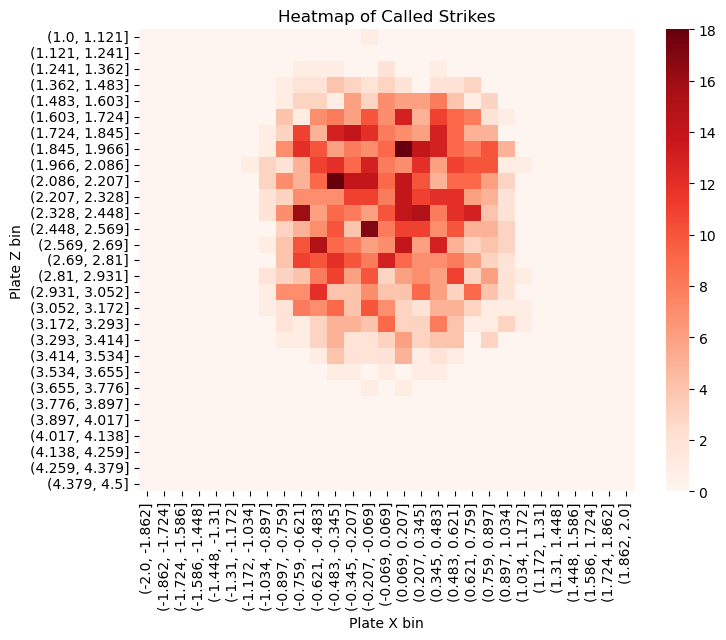

In [111]:
pirates_data['plate_x_bin'] = pd.cut(pirates_data['plate_x'], bins=np.linspace(-2, 2, 30))
pirates_data['plate_z_bin'] = pd.cut(pirates_data['plate_z'], bins=np.linspace(1, 4.5, 30))

# Choose called strikes
called_strikes = pirates_data[pirates_data['description'].isin(['called_strike'])]

heatmap_data = (called_strikes
                .groupby(['plate_x_bin', 'plate_z_bin'])
                .size()
                .unstack()
                .fillna(0))

plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data.T, cmap='Reds', cbar=True)
plt.title("Heatmap of Called Strikes")
plt.xlabel("Plate X bin")
plt.ylabel("Plate Z bin")
plt.show()


Optimization terminated successfully.
         Current function value: 0.579211
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:        is_strike_pitch   No. Observations:                 9587
Model:                          Logit   Df Residuals:                     9581
Method:                           MLE   Df Model:                            5
Date:                Fri, 13 Jun 2025   Pseudo R-squ.:                 0.02618
Time:                        16:40:11   Log-Likelihood:                -5552.9
converged:                       True   LL-Null:                       -5702.2
Covariance Type:            nonrobust   LLR p-value:                 2.073e-62
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                            -1.3626      0.059    -23

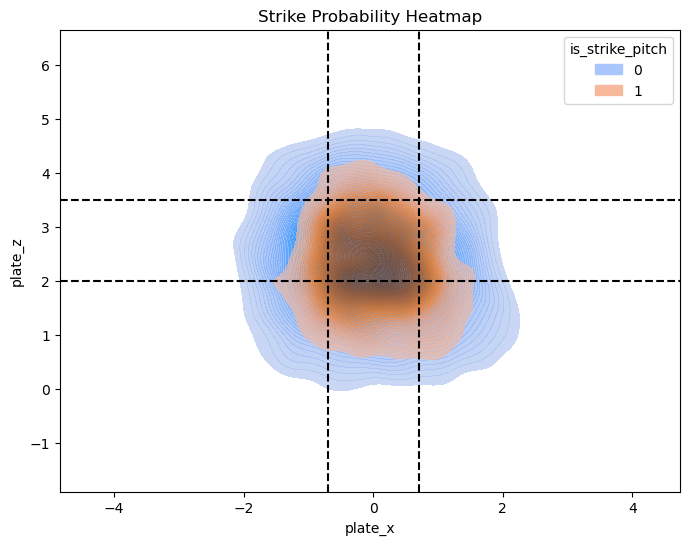

In [112]:

df = data.copy()

# Target variable: was the pitch called a strike or resulted in a swinging strike
df['is_strike_pitch'] = df['description'].isin(['called_strike', 'swinging_strike', 'foul_tip', 'swinging_strike_blocked']).astype(int)

# Strike zone definition (adjust as needed)
x_min, x_max = -0.7, 0.7
z_min, z_max = 2.0, 3.5
df['in_strike_zone'] = ((df['plate_x'] >= x_min) & (df['plate_x'] <= x_max) &
                        (df['plate_z'] >= z_min) & (df['plate_z'] <= z_max)).astype(int)

# Encode p_throws as binary
df = df[df['p_throws'].isin(['R', 'L'])]
df['p_throws_encoded'] = df['p_throws'].map({'R':1, 'L':0}).astype(int)

# Encode pitch_type
df = df[df['pitch_type'].notnull()]
df['pitch_type_encoded'] = pd.factorize(df['pitch_type'])[0]

# Drop missing coordinate rows
df = df.dropna(subset=['plate_x', 'plate_z'])

# Features for factor model
features = ['in_strike_zone', 'p_throws_encoded', 'pitch_type_encoded',
            'in_strike_zone:p_throws_encoded', 'in_strike_zone:pitch_type_encoded']

# Formula for statsmodels
formula = 'is_strike_pitch ~ in_strike_zone + p_throws_encoded + pitch_type_encoded + in_strike_zone:p_throws_encoded + in_strike_zone:pitch_type_encoded'

# === logit ===
model = smf.logit(formula=formula, data=df).fit()
print(model.summary())

# === (AME) ===
mfx = model.get_margeff()
print(mfx.summary())

# STRIKE ZONE HEATMAP 
plt.figure(figsize=(8,6))
hb = sns.kdeplot(
    data=df, x='plate_x', y='plate_z', hue='is_strike_pitch', fill=True, common_norm=False,
    palette='coolwarm', levels=50, alpha=0.7
)
plt.axvline(x=x_min, color='black', linestyle='--')
plt.axvline(x=x_max, color='black', linestyle='--')
plt.axhline(y=z_min, color='black', linestyle='--')
plt.axhline(y=z_max, color='black', linestyle='--')
plt.title('Strike Probability Heatmap')
plt.xlabel('plate_x')
plt.ylabel('plate_z')
plt.show()


## Playground for XGBoost and logit

In [113]:
# Define the strike pitch labels
strike_labels = ['called_strike', 'swinging_strike', 'foul_tip', 'swinging_strike_blocked']

# 0. Create binary target variable
pirates_data['is_strike_pitch'] = pirates_data['description'].isin(strike_labels).astype(int)
pirates_data = pirates_data.drop(columns=['description'])


# 1. Compute missing fractions
missing_frac = pirates_data.isna().mean()

# Drop columns with >30% missing
cols_to_drop = missing_frac[missing_frac > 0.3].index.tolist()
data_clean = pirates_data.drop(columns=cols_to_drop).copy()

print(f"Dropped {len(cols_to_drop)} columns with >30% missing.")

# 2. Handle low-missing columns (≤5%) first
missing_frac = data_clean.isna().mean()
cols_low_missing = missing_frac[missing_frac <= 0.05].index.tolist()
cols_high_missing = missing_frac[(missing_frac > 0.05) & (missing_frac <= 0.3)].index.tolist()

numeric_cols = data_clean[cols_low_missing].select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = data_clean[cols_low_missing].select_dtypes(include=['object', 'category']).columns.tolist()

# Median impute numeric low-missing columns
for col in numeric_cols:
    if data_clean[col].isna().any():
        data_clean[col] = data_clean[col].fillna(data_clean[col].median())

# Mode impute categorical low-missing columns
for col in categorical_cols:
    if data_clean[col].isna().any():
        mode_val = data_clean[col].mode()[0]
        data_clean[col] = data_clean[col].fillna(mode_val)

# 3. Handle high-missing columns (5-30%)
for col in cols_high_missing:
    if data_clean[col].dtype in [np.float64, np.int64]:  # Numeric
        data_clean[f'{col}_missing'] = data_clean[col].isna().astype(int)
        data_clean[col] = data_clean[col].fillna(0)
    else:  # Categorical
        data_clean[f'{col}_missing'] = data_clean[col].isna().astype(int)
        data_clean[col] = data_clean[col].astype('category')

# 4. One-hot encode categorical variables (both low-missing and high-missing)
categorical_cols_all = data_clean.select_dtypes(include=['object', 'category']).columns.tolist()
data_clean = pd.get_dummies(data_clean, columns=categorical_cols_all, drop_first=True, dtype=int)

# 5. Create 'in_strike_zone' dummy based on plate_x and plate_z
x_min, x_max = -0.7, 0.7
z_min, z_max = 2.0, 3.5
data_clean['in_strike_zone'] = (
    (data_clean['plate_x'] >= x_min) & (data_clean['plate_x'] <= x_max) &
    (data_clean['plate_z'] >= z_min) & (data_clean['plate_z'] <= z_max)
).astype(int)

# 6. One-hot encode pitch_name separately
pitch_dummies = pd.get_dummies(pirates_data['pitch_name'], prefix='pitch', drop_first=True, dtype=int)

# 7. Create interaction terms between pitch dummies and in_strike_zone
interaction_terms = pitch_dummies.multiply(data_clean['in_strike_zone'], axis=0)
interaction_terms.columns = [f"{col}_x_in_strike_zone" for col in interaction_terms.columns]

# 8. Concatenate all together
data_clean = pd.concat([data_clean, pitch_dummies, interaction_terms], axis=1)

# 9. Final cleanup: ensure numeric
data_clean = data_clean.apply(pd.to_numeric, errors='coerce')

# 10. Add constant for intercept
data_clean['const'] = 1

print(f"Final cleaned data shape: {data_clean.shape}")


Dropped 35 columns with >30% missing.
Final cleaned data shape: (9587, 2412)


In [114]:
def clean_col_name(name):
    name = name.replace(' ', '_').replace('.', '').replace(',', '')
    return re.sub(r'[^A-Za-z0-9_]+', '', name)

# Create a dict mapping old names to cleaned names
new_columns = {col: clean_col_name(col) for col in data_clean.columns}

# Rename columns in place
data_clean.rename(columns=new_columns, inplace=True)

def build_ols(data, target,  pval_thresh=0.05):
    """Builds OLS model with splines for significant numeric predictors."""
    numeric_predictors = [col for col in data.columns 
                          if col != target and data[col].dtype in [np.float64, np.int64]]
    
    # Quick OLS to find significant numeric predictors
    X_full = sm.add_constant(data[numeric_predictors])
    initial_model = sm.OLS(data[target], X_full).fit()
    significant_numeric = [var for var in numeric_predictors 
                           if var in initial_model.pvalues and initial_model.pvalues[var] < pval_thresh]
    
    print(f"Significant numeric predictors (p<{pval_thresh}): {significant_numeric}")
    return significant_numeric


In [115]:
significant_numeric = build_ols(data_clean, target='is_strike_pitch')


Significant numeric predictors (p<0.05): ['release_speed', 'balls', 'strikes', 'vy0', 'sz_top', 'sz_bot', 'effective_speed', 'release_pos_y', 'pitch_number', 'away_score', 'bat_score', 'fld_score', 'post_away_score', 'post_bat_score', 'post_fld_score', 'delta_run_exp', 'delta_pitcher_run_exp', 'bat_score_diff', 'api_break_x_arm', 'pitcher_days_until_next_game_missing', 'pitch_type_FC', 'pitch_type_FS', 'game_date_20250408', 'player_name_Santana_Dennis', 'des_Agustn_Ramrez_grounds_out_shortstop_Jared_Triolo_to_first_baseman_Spencer_Horwitz', 'des_Andy_Pages_doubles_3_on_a_line_drive_to_right_fielder_Bryan_Reynolds', 'des_Austin_Wells_grounds_out_sharply_second_baseman_Jared_Triolo_to_first_baseman_Endy_Rodrguez', 'des_Blake_Dunn_called_out_on_strikes', 'des_Brandon_Nimmo_flies_out_to_left_fielder_Alexander_Canario', 'des_Brayan_Rocchio_walks', 'des_Brendan_Donovan_called_out_on_strikes', 'des_Bryson_Stott_strikes_out_swinging', 'des_Caleb_Durbin_doubles_6_on_a_fly_ball_to_left_fielder_T

In [116]:
# Features of interest: pitch dummies + their interaction terms
pitch_features = [
    'pitch_Changeup', 'pitch_Curveball', 'pitch_Cutter', 'pitch_Sinker', 'pitch_Slider',
    'pitch_Slow Curve', 'pitch_Slurve', 'pitch_Split-Finger', 'pitch_Sweeper'
]
interaction_features = [f"{feat}_x_in_strike_zone" for feat in pitch_features]
selected_features = [f for f in pitch_features + interaction_features if f in data_clean.columns]

In [117]:
selected_features

['pitch_Changeup',
 'pitch_Curveball',
 'pitch_Cutter',
 'pitch_Sinker',
 'pitch_Slider',
 'pitch_Slurve',
 'pitch_Sweeper',
 'pitch_Changeup_x_in_strike_zone',
 'pitch_Curveball_x_in_strike_zone',
 'pitch_Cutter_x_in_strike_zone',
 'pitch_Sinker_x_in_strike_zone',
 'pitch_Slider_x_in_strike_zone',
 'pitch_Slurve_x_in_strike_zone',
 'pitch_Sweeper_x_in_strike_zone']

Duplicate columns: ['pitch_Cutter', 'pitch_Changeup_x_in_strike_zone', 'pitch_Curveball_x_in_strike_zone', 'pitch_Cutter_x_in_strike_zone', 'pitch_Sinker_x_in_strike_zone', 'pitch_Sweeper_x_in_strike_zone']

Highly correlated variable pairs (corr > 0.9):
vy0 and release_speed: 1.000
effective_speed and release_speed: 0.994
effective_speed and vy0: 0.995
post_away_score and away_score: 0.998
post_bat_score and bat_score: 0.996
post_fld_score and fld_score: 1.000
delta_pitcher_run_exp and delta_run_exp: 1.000
pitch_name_Cutter and pitch_type_FC: 1.000
pitch_name_SplitFinger and pitch_type_FS: 1.000
pitch_Cutter and pitch_type_FC: 1.000
pitch_Cutter and pitch_name_Cutter: 1.000
pitch_SplitFinger and pitch_type_FS: 1.000
pitch_SplitFinger and pitch_name_SplitFinger: 1.000

Dropping correlated columns: ['delta_pitcher_run_exp', 'post_bat_score', 'post_away_score', 'pitch_Cutter', 'pitch_name_SplitFinger', 'pitch_name_Cutter', 'pitch_SplitFinger', 'post_fld_score', 'vy0', 'effective_speed']


/opt/anaconda3/envs/catboost-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [16:40:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.90      0.94      6884
           1       0.80      0.96      0.87      2703

    accuracy                           0.92      9587
   macro avg       0.89      0.93      0.91      9587
weighted avg       0.93      0.92      0.92      9587

ROC AUC: 0.9810
Brier Score: 0.0536


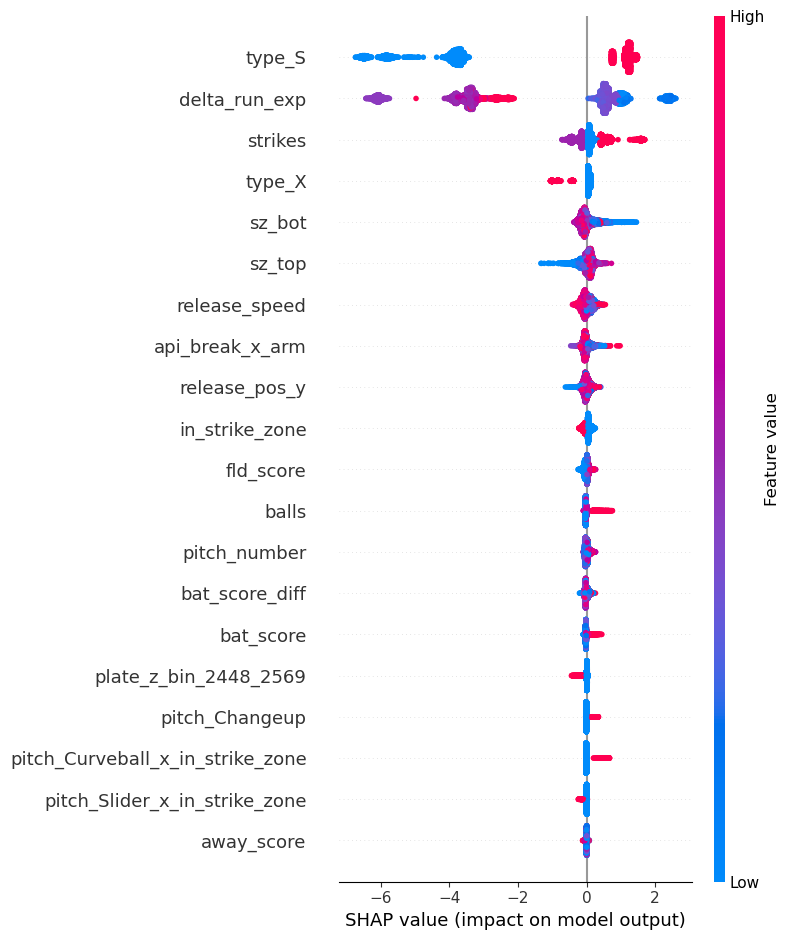

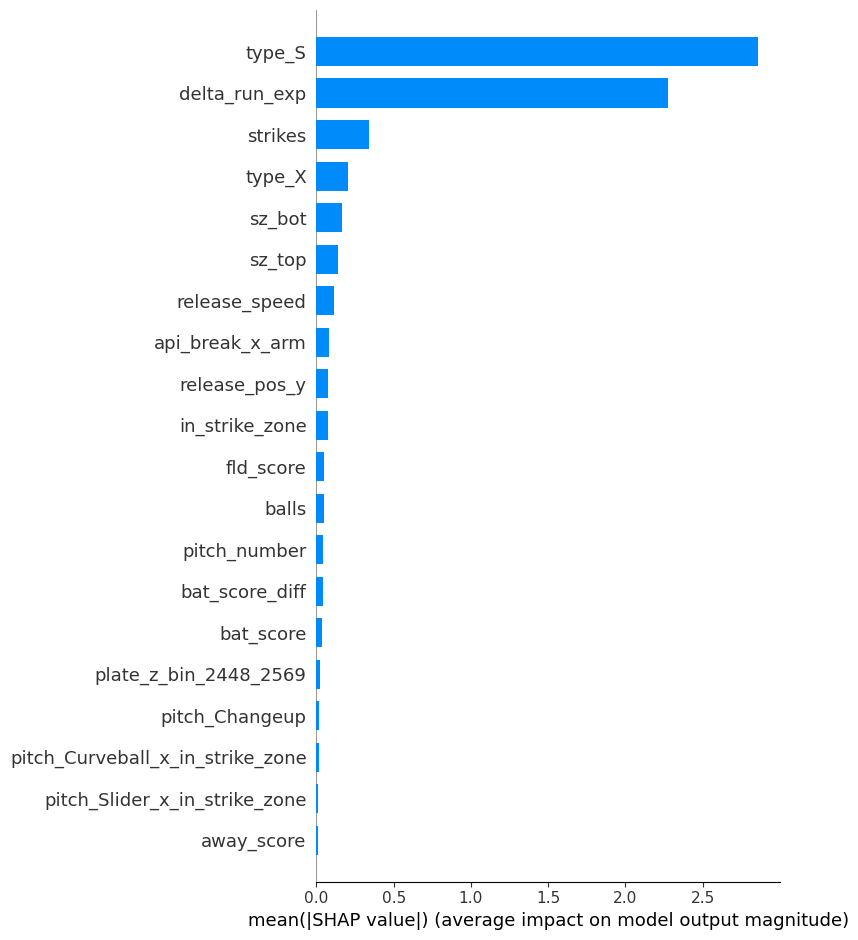

In [118]:
data_XGB = data_clean[significant_numeric + selected_features + ['const']]

# 1. Remove duplicate columns, keep first occurrence
duplicates = data_XGB.columns[data_XGB.columns.duplicated()]
print("Duplicate columns:", duplicates.tolist())

X = data_XGB.loc[:, ~data_XGB.columns.duplicated()]

# 2. Compute correlation matrix and select upper triangle
corr_matrix = X.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# 3. Find highly correlated variable pairs (threshold = 0.9)
high_corr = []
for col in upper.columns:
    for row in upper.index:
        corr_value = upper.loc[row, col]
        if pd.notnull(corr_value) and corr_value > 0.9:
            high_corr.append((col, row, corr_value))

print("\nHighly correlated variable pairs (corr > 0.9):")
for var1, var2, corr_value in high_corr:
    print(f"{var1} and {var2}: {corr_value:.3f}")

# 4. Drop one of each pair (keep the first, drop the second)
to_drop = list(set([var1 for var1, var2, _ in high_corr]))
print("\nDropping correlated columns:", to_drop)
X = X.drop(columns=to_drop)
X = X.drop(X.columns[16:98], axis=1)
X = sm.add_constant(X.drop(columns=['const'], errors='ignore'))
y = y

# Remove multicollinearity
X = X.reset_index(drop=True)
y = y.reset_index(drop=True)

#X = remove_multicollinearity(X, y, threshold=0.8)

# Split data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=15217, stratify=y
)

# Convert train and val sets to numpy float32 arrays for XGBoost
X_train_np = X_train.astype(np.float32).values
X_val_np = X_val.astype(np.float32).values
y_train_np = y_train.values
y_val_np = y_val.values

# Initialize XGBoost classifier
xgb_clf = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    n_estimators=200,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=15217,
    n_jobs=-1,
    verbosity=2
)

# Fit model with evaluation monitoring
xgb_clf.fit(
    X_train_np, y_train_np,
    eval_set=[(X_val_np, y_val_np)],
    verbose=50
)

# Predict on full dataset
X_np = X.astype(np.float32).values
y_pred_prob = xgb_clf.predict_proba(X_np)[:, 1]
y_pred = xgb_clf.predict(X_np)

# Print classification report and metrics
print("Classification Report:\n", classification_report(y, y_pred))
print(f"ROC AUC: {roc_auc_score(y, y_pred_prob):.4f}")
print(f"Brier Score: {brier_score_loss(y, y_pred_prob):.4f}")

# SHAP explanation
explainer = shap.TreeExplainer(xgb_clf)

try:
    shap_values = explainer.shap_values(X_np)
except AttributeError:
    shap_values = explainer(X_np).values

# Use DataFrame for nicer plot labels
X_for_plot = pd.DataFrame(X_np, columns=X.columns)

# SHAP summary plots
shap.summary_plot(shap_values, X_for_plot, plot_type="dot")
shap.summary_plot(shap_values, X_for_plot, plot_type="bar")


Duplicate columns: ['pitch_Cutter', 'pitch_Changeup_x_in_strike_zone', 'pitch_Curveball_x_in_strike_zone', 'pitch_Cutter_x_in_strike_zone', 'pitch_Sinker_x_in_strike_zone', 'pitch_Sweeper_x_in_strike_zone']

Highly correlated variable pairs (corr > 0.9):
vy0 and release_speed: 1.000
effective_speed and release_speed: 0.994
effective_speed and vy0: 0.995
post_away_score and away_score: 0.998
post_bat_score and bat_score: 0.996
post_fld_score and fld_score: 1.000
delta_pitcher_run_exp and delta_run_exp: 1.000
pitch_name_Cutter and pitch_type_FC: 1.000
pitch_name_SplitFinger and pitch_type_FS: 1.000
pitch_Cutter and pitch_type_FC: 1.000
pitch_Cutter and pitch_name_Cutter: 1.000
pitch_SplitFinger and pitch_type_FS: 1.000
pitch_SplitFinger and pitch_name_SplitFinger: 1.000

Dropping correlated columns: ['delta_pitcher_run_exp', 'post_bat_score', 'post_away_score', 'pitch_Cutter', 'pitch_name_SplitFinger', 'pitch_name_Cutter', 'pitch_SplitFinger', 'post_fld_score', 'vy0', 'effective_speed']


/opt/anaconda3/envs/catboost-env/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/catboost-env/lib/python3.9/site-packages/statsmodels/discrete/discrete_margins.py:343: RuntimeWarning: invalid value encountered in sqrt
  return cov_me, np.sqrt(np.diag(cov_me))
/var/folders/s3/fhd2___139j3q9bqq_cl4q740000gn/T/ipykernel_14676/2768025461.py:55: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(x='dy/dx', y='Variable', data=ame_df, join=False, color='blue')


        Logit Marginal Effects       
Dep. Variable:        is_strike_pitch
Method:                          dydx
At:                           overall
                                          dy/dx    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
release_speed                           -0.0006      0.001     -0.620      0.535      -0.002       0.001
balls                                   -0.0077      0.016     -0.473      0.636      -0.040       0.024
strikes                                 -0.1024      0.018     -5.767      0.000      -0.137      -0.068
sz_top                                   0.1225      0.026      4.779      0.000       0.072       0.173
sz_bot                                  -0.1812      0.042     -4.296      0.000      -0.264      -0.099
release_pos_y                            0.0060      0.009      0.703      0.482      -0.011       0.023
pitch_nu

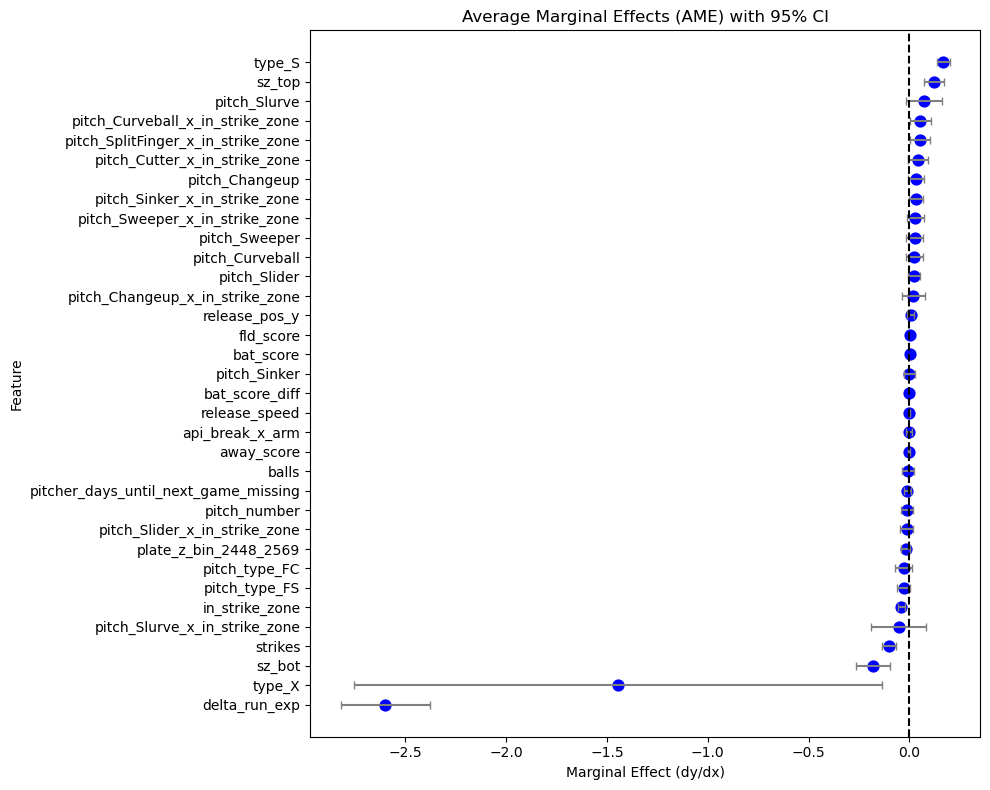


Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.89      0.93      6884
           1       0.76      0.92      0.84      2703

    accuracy                           0.90      9587
   macro avg       0.87      0.91      0.88      9587
weighted avg       0.91      0.90      0.90      9587

ROC AUC: 0.9573
Brier Score: 0.0690
Precision: 0.7649
Recall: 0.9219
F1 Score: 0.8361


In [119]:
# === Prepare data ===
# Start with your selected data
data_logit = data_clean[significant_numeric + selected_features + ['const']]

# 1. Remove duplicate columns, keep first occurrence
duplicates = data_logit.columns[data_logit.columns.duplicated()]
print("Duplicate columns:", duplicates.tolist())

X = data_logit.loc[:, ~data_logit.columns.duplicated()]

# 2. Compute correlation matrix and select upper triangle
corr_matrix = X.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# 3. Find highly correlated variable pairs (threshold = 0.9)
high_corr = []
for col in upper.columns:
    for row in upper.index:
        corr_value = upper.loc[row, col]
        if pd.notnull(corr_value) and corr_value > 0.9:
            high_corr.append((col, row, corr_value))

print("\nHighly correlated variable pairs (corr > 0.9):")
for var1, var2, corr_value in high_corr:
    print(f"{var1} and {var2}: {corr_value:.3f}")

# 4. Drop one of each pair (keep the first, drop the second)
to_drop = list(set([var1 for var1, var2, _ in high_corr]))
print("\nDropping correlated columns:", to_drop)
X = X.drop(columns=to_drop)
X = X.drop(X.columns[16:98], axis=1)
X = sm.add_constant(X.drop(columns=['const'], errors='ignore'))
y = y

# === Fit logistic regression ===
logit_model = sm.Logit(y, X)
#logit_model = sm.OLS(y, X)
result = logit_model.fit(disp=True)

# === Print summary ===
print(result.summary())

# === Marginal Effects (Average Marginal Effects, AME) ===
marginal_effects = result.get_margeff()
print(marginal_effects.summary())

# === Confidence intervals for AME ===
ame_df = marginal_effects.summary_frame().reset_index().rename(columns={'index': 'Variable'})
ame_df = ame_df.sort_values(by='dy/dx', ascending=False)
print(ame_df.columns)
ame_df = ame_df.rename(columns={'Cont. Int. Hi.': 'Conf. Int. Up'})

# === Plot AME with confidence intervals ===
plt.figure(figsize=(10, 8))
sns.pointplot(x='dy/dx', y='Variable', data=ame_df, join=False, color='blue')
plt.errorbar(
    ame_df['dy/dx'], ame_df['Variable'], 
    xerr=[ame_df['dy/dx'] - ame_df['Conf. Int. Low'], ame_df['Conf. Int. Up'] - ame_df['dy/dx']],
    fmt='none', ecolor='gray', capsize=3
)

plt.axvline(0, color='black', linestyle='--')
plt.title('Average Marginal Effects (AME) with 95% CI')
plt.xlabel('Marginal Effect (dy/dx)')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

# === Predictions ===
y_pred_prob = result.predict(X)
y_pred = (y_pred_prob >= 0.5).astype(int)

# === Evaluation metrics ===
print("\nClassification Report:")
print(classification_report(y, y_pred))

print(f"ROC AUC: {roc_auc_score(y, y_pred_prob):.4f}")
print(f"Brier Score: {brier_score_loss(y, y_pred_prob):.4f}")
print(f"Precision: {precision_score(y, y_pred):.4f}")
print(f"Recall: {recall_score(y, y_pred):.4f}")
print(f"F1 Score: {f1_score(y, y_pred):.4f}")


## Observation
What we can see that being in_strike_zone has insignificant effect on predicting strikes, however most interaction terms by differnt pitch types have small but positive marginal effect on strike, except Slurve pitch.